In [4]:
import tensorflow as tf
from keras.models import Model
from keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np

In [75]:
data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/'
data_dir = pathlib.Path(data_dir)
test_dir = pathlib.Path(test_dir)
print(data_dir,test_dir)
# count how many images are there
image_count = len(list(test_dir.glob('*.jpg')))

#data_dir.glob("*/*.jpg")
#glob.glob('*/*.jpg')
#image_count = len(list(os.listdir(data_dir('*/*.jpg'))))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
image_count,len(CLASS_NAMES)

/Users/priya/Desktop/classes-master/shopee_product_detection/data/train /Users/priya/Desktop/classes-master/shopee_product_detection/data/test


(12192, 42)

In [43]:
#This function extracts the dataset, and then uses the ImageDataGenerator keras utility class 
#to wrap the dataset in a Python generator (so the images only loads to memory by batches, not in one shot).

from tensorflow.keras.applications.mobilenet import MobileNet as preprocess_input
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05) #,preprocessing_function=preprocess_input

def load_data(data_dir):
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    #data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    #                                     fname='flower_photos', untar=True)
    #data_dir = pathlib.Path(data_dir)
    #data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of items) excluding .DS_Store file #folders are classes
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1./255., validation_split=0.2,**img_gen_args)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    
    return train_data_gen, test_data_gen, CLASS_NAMES

In [205]:
def create_model(input_shape):
    # load MobileNetV2
    #model = MobileNetV2(input_shape=input_shape)
    model = MobileNetV2(input_shape=input_shape,weights='imagenet')
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    #model.summary()
    # training the model using rmsprop optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print("Model created")
    return model

In [206]:
batch_size = 32
num_classes = 42
epochs = 40
IMAGE_SHAPE = (224, 224, 3)

In [207]:
#from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#filepath = 'full_data_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10)


data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'


    # load the data generators
train_generator, validation_generator, class_names = load_data(data_dir)
    # constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
    # model name
    #model_name = "MobileNetV2_finetune_last5"
    # some nice callbacks
    #tensorboard = TensorBoard(log_dir=f"logs/{model_name}")
filepath = 'MobileNet_{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [checkpoint,early_stops]
    #checkpoint = ModelCheckpoint(f"results/{model_name}" + "-loss-{val_loss:.2f}-acc-{val_acc:.2f}.h5",
    #                            save_best_only=True,
    #                            verbose=1)
    # make sure results folder exist
    #if not os.path.isdir("results"):
    #    os.mkdir("results")
    # count number of steps per epoch
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
    # train using the generators
history = model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[checkpoint,early_stops])
    
    #val_loss.append(history.history['val_loss'][0])
    #print("{} val_loss is {}".format(epochs,val_loss))
    
    #validation_loss = history.history['val_loss'][0]
    #print("{} validation_loss is {}".format(epochs,validation_loss))

Number of images: 105392
Found 84331 images belonging to 42 classes.
Found 21061 images belonging to 42 classes.
Model created
Epoch 1/40
2636/2636 [==============================] - ETA: 0s - loss: 2.9460 - accuracy: 0.3777
Epoch 00001: val_loss improved from inf to 2.39394, saving model to MobileNet_001_acc0.378_loss2.946_val_acc0.413_val_loss2.394.h5
2636/2636 [==============================] - 5348s 2s/step - loss: 2.9460 - accuracy: 0.3777 - val_loss: 2.3939 - val_accuracy: 0.4135
Epoch 2/40
2636/2636 [==============================] - ETA: 0s - loss: 2.1483 - accuracy: 0.4184
Epoch 00002: val_loss improved from 2.39394 to 1.99872, saving model to MobileNet_002_acc0.418_loss2.148_val_acc0.424_val_loss1.999.h5
2636/2636 [==============================] - 2280s 865ms/step - loss: 2.1483 - accuracy: 0.4184 - val_loss: 1.9987 - val_accuracy: 0.4240
Epoch 3/40
2636/2636 [==============================] - ETA: 0s - loss: 1.9113 - accuracy: 0.4313
Epoch 00003: val_loss improved from 1.99

2636/2636 [==============================] - 2370s 899ms/step - loss: 1.2669 - accuracy: 0.6183 - val_loss: 1.5179 - val_accuracy: 0.5759
Epoch 24/40
2636/2636 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.6225
Epoch 00024: val_loss improved from 1.51790 to 1.49778, saving model to MobileNet_024_acc0.622_loss1.256_val_acc0.579_val_loss1.498.h5
2636/2636 [==============================] - 2367s 898ms/step - loss: 1.2561 - accuracy: 0.6225 - val_loss: 1.4978 - val_accuracy: 0.5792
Epoch 25/40
2636/2636 [==============================] - ETA: 0s - loss: 1.2370 - accuracy: 0.6303
Epoch 00025: val_loss improved from 1.49778 to 1.49696, saving model to MobileNet_025_acc0.630_loss1.237_val_acc0.587_val_loss1.497.h5
2636/2636 [==============================] - 2360s 895ms/step - loss: 1.2370 - accuracy: 0.6303 - val_loss: 1.4970 - val_accuracy: 0.5870
Epoch 26/40
2636/2636 [==============================] - ETA: 0s - loss: 1.2260 - accuracy: 0.6373
Epoch 00026: val_lo

In [50]:
history.history['val_loss'][:5]

[2.39953875541687,
 2.0305070877075195,
 1.9287219047546387,
 1.8676148653030396,
 1.8535268306732178]

In [49]:
from keras.models import load_model
model_name = '037_acc0.710_loss1.040_val_acc0.645_val_loss1.405.h5'
model = load_model(model_name)

In [51]:
evaluation = model.evaluate_generator(validation_generator, steps=validation_steps_per_epoch, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
659/659 [==============================] - 466s 708ms/step - loss: 1.3981 - accuracy: 0.6470


In [53]:
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

Val loss: 1.3981269598007202
Val Accuracy: 0.6470252871513367


In [191]:
from keras.optimizers import Adam
model_name = '037_acc0.710_loss1.040_val_acc0.645_val_loss1.405.h5'
model = load_model(model_name)

#base_learning_rate = 0.001 #default is 0.01
#The model returned by load_model() is a compiled model ready to be used unless the saved model was not compiled. Re-compiling the model will reset the state of the model.


#model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])

#base_learning_rate = 0.0001
#model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])

In [194]:
import keras
from keras import backend as K
# To get learning rate
print(K.get_value(model.optimizer.lr))
# To set learning rate
K.set_value(model.optimizer.lr, 0.0001)
print(K.get_value(model.optimizer.lr))
keras.__version__ # 2.0.2

0.001
1e-04


'2.4.2'

In [195]:
batch_size = 16
epochs = 100


training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)

filepath = 'MobileNet_{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [checkpoint,early_stops]

history1 = model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[checkpoint,early_stops])

Epoch 1/100
5271/5271 [==============================] - ETA: 0s - loss: 0.9691 - accuracy: 0.7280
Epoch 00001: val_loss improved from inf to 1.38467, saving model to 001_acc0.728_loss0.969_val_acc0.653_val_loss1.385.h5
5271/5271 [==============================] - 10021s 2s/step - loss: 0.9691 - accuracy: 0.7280 - val_loss: 1.3847 - val_accuracy: 0.6526
Epoch 2/100
5271/5271 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.7302
Epoch 00002: val_loss improved from 1.38467 to 1.38324, saving model to 002_acc0.730_loss0.956_val_acc0.653_val_loss1.383.h5
5271/5271 [==============================] - 10520s 2s/step - loss: 0.9557 - accuracy: 0.7302 - val_loss: 1.3832 - val_accuracy: 0.6533
Epoch 3/100
5271/5271 [==============================] - ETA: 0s - loss: 0.9480 - accuracy: 0.7318
Epoch 00003: val_loss did not improve from 1.38324
5271/5271 [==============================] - 9583s 2s/step - loss: 0.9480 - accuracy: 0.7318 - val_loss: 1.3844 - val_accuracy: 0.6503

KeyboardInterrupt: 

In [196]:
model_name = '007_acc0.737_loss0.928_val_acc0.655_val_loss1.367.h5'
model = load_model(model_name)



IndexError: index 16 is out of bounds for axis 0 with size 16

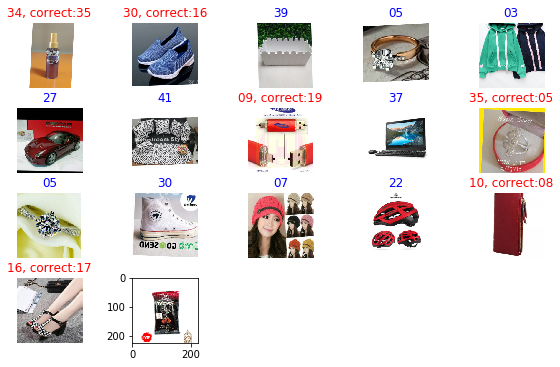

In [197]:
import matplotlib.pyplot as plt
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
#print(image_batch)
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
#print(image_batch) #array
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()

In [198]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/'
# should have 1 more directory with images in it.
test_datagen = ImageDataGenerator(rescale=1./255.,**img_gen_args)
test_generator = test_datagen.flow_from_directory(
    directory=str(test_dir),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)
#next(test_generator)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset() #very important
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

#predicted_class_indices=np.argmax(pred,axis=1)

Found 12192 images belonging to 1 classes.
12192/12192 [==============================] - 677s 56ms/step


In [199]:
import pandas as pd
predicted_class_indices=np.argmax(pred,axis=1)
#predicted_class_indices

#Next step is I want the name of the classes:

labels = (train_generator.class_indices)
predicted_class_indices,labels
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
#Where by class numbers will be replaced by the class names. One final step if you want to save it to a csv file, arrange it in a dataframe with the image names appended with the class predicted.

filenames=test_generator.filenames

aresults=pd.DataFrame({"filename":filenames,
                      "category":predictions})

In [200]:
aresults['filename'] = aresults['filename'].apply(lambda x: x.split("/")[1])
aresults.head()

,filename,category
0,0004b03ad7eabfb3989727c461310a84.jpg,12
1,0004d34271d0a0253f8a95d0746bae05.jpg,05
2,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,39
3,0012f125ad07123e69468ae1d1d59de4.jpg,22
4,0015831b249b856e569e883a9dc6d4fa.jpg,12


In [201]:
test = pd.read_csv('../data/test.csv')
test.shape

(12186, 2)

In [202]:
test.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [203]:
dff1 = pd.merge(test, aresults, how='left', on=['filename'])[['filename','category_y']]
dff1.columns=['filename','category']

In [204]:
dff1.to_csv("submission_labels_after_2ndrun.csv",index=False)

# Method 2

In [1]:
import pandas as pd
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from keras.models import Model

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../data/train.csv')
train.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [3]:
train_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
train['path'] = train_dir + train['category'].apply(lambda x: str(x)+"/" if len(str(x))>1 else "0"+str(x)+"/") + train['filename'].apply(lambda x: x)
train.head()

,filename,category,path
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
2,f6c172096818c5fab10ecae722840798.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
3,251ffd610399ac00fea7709c642676ee.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
4,73c7328b8eda399199fdedec6e4badaf.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...


In [4]:
train['category'].nunique()

42

In [5]:
#train['y_vector'] = train['category'].apply(lambda x: np.pad(to_categorical(3), (0, 42-len(to_categorical(3))), 'constant', constant_values=0.0))
#train.head()

In [6]:
#train['y_vector'][0].tolist() # converts numpy array to list
#train['y_vector'] = train['category'].apply(lambda x: (np.pad(to_categorical(3), (0, 42-len(to_categorical(3))), 'constant', constant_values=0.0)).tolist())
#train.head()

In [7]:
test = pd.read_csv('../data/test.csv')
test.head()
test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/'
test['path'] = test_dir + test['filename'].apply(lambda x: x)
test.head()

,filename,category,path
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
2,127f3e6d6e3491b2459812353f33a913.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
4,46d681a542f2c71be017eef6aae23313.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...


In [8]:
test['path'][0]

'/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg'

In [9]:
#def pad(l, size, padding): for list
#    return l + [padding] * abs((len(l)-size))

#l = [1,2,3]
#pad(l, 7, 0)
#[1, 2, 3, 0, 0, 0, 0]

In [10]:
#len(train['y_vector'][3456])

In [11]:
# One-hot encode the output variable
#y=train['category'].values
#y = to_categorical(y)
#y.shape

In [21]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.25, random_state=42,
                                    stratify=train['category'])
print(train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(79044, 3) training data
(26348, 3) validation data


In [22]:
train.dtypes
train['category'] = train['category'].astype(str)
train.dtypes

filename    object
category    object
path        object
dtype: object

In [23]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#def prepare_image(file):
#    #img_path = ''
    #img = image.load_img(img_path + file, target_size=(224, 224))
#    image = load_img(file, target_size=(224, 224))
#    img_array = img_to_array(image)
#    features_array = preprocess_input(img_array)
#    img_array_expanded_dims = np.expand_dims(features_array, axis=0)
#    print(img_array_expanded_dims.shape)
    #return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [24]:
#mobile = keras.applications.mobilenet.MobileNet()
from tensorflow.keras.applications.mobilenet import MobileNet as PTModel,preprocess_input
def prepare_image(file):
    img = load_img(file, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    print(preprocess_input(img_array_expanded_dims).shape)
    return preprocess_input(img_array_expanded_dims)

In [25]:
prepare_image('/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg')

(1, 224, 224, 3)


array([[[[-0.9997232 , -0.99947715, -0.99929255],
         [-0.9996617 , -0.9996002 , -0.99947715],
         [-0.99953866, -0.99953866, -0.99941564],
         ...,
         [-1.0017532 , -1.0016302 , -1.0018147 ],
         [-1.0016302 , -1.0015072 , -1.0016917 ],
         [-1.0016917 , -1.0015687 , -1.0017532 ]],

        [[-1.0007074 , -1.0004613 , -1.0005229 ],
         [-1.0024298 , -1.0023068 , -1.0023683 ],
         [-1.0020608 , -1.0020608 , -1.0020608 ],
         ...,
         [-1.0018147 , -1.0018147 , -1.0018147 ],
         [-1.0015687 , -1.0015687 , -1.0015687 ],
         [-1.0015687 , -1.0015687 , -1.0015687 ]],

        [[-0.99941564, -0.999108  , -0.99953866],
         [-0.99873894, -0.9986159 , -0.9989235 ],
         [-0.99996924, -0.99996924, -1.0000923 ],
         ...,
         [-1.0019993 , -1.0021223 , -1.0019377 ],
         [-1.0016917 , -1.0018147 , -1.0016302 ],
         [-1.0016302 , -1.0017532 , -1.0015687 ]],

        ...,

        [[-1.0029219 , -1.0042138 , -1

In [ ]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)

In [26]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25,****img_gen_args)

In [27]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
#directory="./train/", #(str)Path to the directory which contains all the images.
#set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
x_col="path",
y_col="category", # contains the class names. None in test_generator
subset="training",
batch_size=32,
color_mode='rgb',
seed=42,
shuffle=True, #Set this to False(For Test generator only, for others set True),
#class_mode="categorical", # (str) Similar to flow_from_directory, 
#this accepts “categorical”(default), ”binary”, ”sparse”, ”input”, None and also an extra argument “raw”.
target_size=(224,224),
#classes=None
#validate_filenames=True
)

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
#directory="./train/",
x_col="path",
y_col="category",
subset="validation",
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=True,
#class_mode="categorical",
target_size=(224,224))

test_datagen=ImageDataGenerator(rescale=1./255.,**img_gen_args)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
#directory="./test/",
x_col="path",
y_col=None, ## contains the class names. None in test_generator
batch_size=18, #Set this to some number that divides your total number of images in your test set exactly.
seed=42,
shuffle=False, #Set this to False(For Test generator only, for others set True),
class_mode=None, # None since we are predicting classes
target_size=(224,224))

Found 79044 validated image filenames belonging to 42 classes.
Found 26348 validated image filenames belonging to 42 classes.
Found 12186 validated image filenames.


In [28]:
IMG_SHAPE = (224, 224, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False
#base_model.summary()

# TRY LATER ---------
#Add a classification head
#To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a 
#tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
#global_average_layer = GlobalAveragePooling2D()

#prediction_layer = Dense(42,activation='softmax')

#model = Sequential()

from keras.layers import Dropout

x=base_model.output
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.3)(x)
#x=Dense(1024,activation='relu')(x) #dense layer 2
#x = Dropout(0.5)(x)
#x=Dense(512,activation='relu')(x) #dense layer 3
#x = Dropout(0.25)(x)
preds=Dense(42,activation='softmax')(x) #final layer with softmax activation
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1024,activation='relu'))
#model.add(Dense(1024,activation='relu')) #dense layer 2
#model.add(Dense(512,activation='relu'))
#model.add(Dense(42,activation='softmax'))


model = Model(inputs=base_model.input,outputs=preds)
#model.summary()
#  global_average_layer,
#  prediction_layer
#])

from keras.optimizers import Adam
base_learning_rate = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])

In [29]:
epochs = 30
batch_size=100
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#filepath = 'full_data_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=0)


filepath = '{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True)

callbacks = [checkpoint,early_stops]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(valid_generator.samples / batch_size)
# train using the generators
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, verbose=1, callbacks=[checkpoint,early_stops])

Epoch 1/30
2470/2470 [==============================] - ETA: 0s - loss: 3.4075 - accuracy: 0.0547
Epoch 00001: val_loss improved from inf to 11.39120, saving model to 001_acc0.055_loss3.408_val_acc0.000_val_loss11.391.h5
2470/2470 [==============================] - 2249s 910ms/step - loss: 3.4075 - accuracy: 0.0547 - val_loss: 11.3912 - val_accuracy: 0.0000e+00
Epoch 2/30
1236/2470 [==============>...............] - ETA: 11:11 - loss: 3.3543 - accuracy: 0.0775

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
pred = model.predict(new_image)

In [ ]:
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=valid_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=10
#)

In [278]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

[13.156620979309082, 0.004111842252314091]

In [305]:
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

380/380 [==============================] - 193s 508ms/step


In [309]:
predicted_class_indices=np.argmax(pred,axis=1)

In [310]:
predicted_class_indices
len(predicted_class_indices)

12160

In [308]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

ValueError: arrays must all be same length

In [284]:
len(predicted_class_indices)

12160

In [313]:
test.head()

,filename,category,path
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
2,127f3e6d6e3491b2459812353f33a913.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
4,46d681a542f2c71be017eef6aae23313.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...


In [318]:
test['filename'].nunique()

12186

In [304]:
12186/26

468.6923076923077

(array([3370., 2660., 2477., 2666., 2247., 2616., 2660., 2419., 2129.,
        3104.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

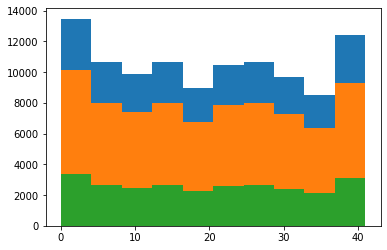

In [206]:
import matplotlib.pyplot as plt
plt.hist(train['category'])
plt.hist(train_df['category'])
plt.hist(valid_df['category'])

In [207]:
#for RGB images, set grayscale as False
#train_image = []
#for i in tqdm(range(train.shape[0])):
    #img = image.load_img('train/'+train['id'][i].astype('str')+'.png', target_size=(28,28,1), grayscale=False)
    #img = image.img_to_array(img)
    #img = img/255
    #train_image.append(img)
#X = np.array(train_image)

In [249]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.mobilenet import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet as PTModel,preprocess_input
#from keras.applications.MobileNetV2 import preprocess_input
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    #print("shape",type(in_df),path_col,len(path_col),type(y_col),y_col)
    print(y_col)
    #print(in_df)
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print(base_dir)
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    print(type(df_gen))
    df_gen.filenames = in_df[path_col].values
    print("file",df_gen.filenames)
    df_gen.classes = np.stack(in_df[y_col].values,0)
    print("clas",df_gen.classes)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [250]:
num_classes = 42
IMG_SIZE = (224,224,3)
BATCH_SIZE = 24

In [251]:
train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                                y_col = 'y_vector',
                            #y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)
print(type(train_gen))
valid_gen = flow_from_dataframe(img_gen, valid_df, 
                             path_col = 'path',
                                y_col = 'y_vector',
                            #y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
#valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
#                               valid_df, 
#                             path_col = 'path',
#                            #y_col = 'class_vec',
#                            y_col = 'y_vector',
#                            target_size = IMG_SIZE,
#                             color_mode = 'rgb',
#                            batch_size = 10)) # one big batch

y_vector
/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/30
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
file ['/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/30/20bd9d6ad2176d336400f1921e1fcde0.jpg'
 '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/03/9e9b47b14e7514608c997c6d97254a19.jpg'
 '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/38/7925f1ee34b3c1e4a0ea7eaa4802e393.jpg'
 ...
 '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/29/331cb01d4dfc38c7ea5a52063a3bf5d0.jpg'
 '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/24/1f51b57e3ae4683ec5529389f3295ac3.jpg'
 '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/01/6cdb5fa7d23a23cd9fd7ca215b052608.jpg']
clas [[0. 0. 0. ... 0. 0. 0.

In [226]:
num_classes = 42
input_shape = (224,224,3)
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#my_new_model = Sequential()
#my_new_model.add(ResNet50(include_top=False, pooling='avg')#, weights=resnet_weights_path))
#my_new_model.add(MobileNetV2(input_shape=input_shape))
#my_new_model.add(Dense(42, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
#my_new_model.layers[0].trainable = False

In [227]:
#def create_model(input_shape):
#    # load MobileNetV2
#    model = MobileNetV2(input_shape=input_shape)
#    # remove the last fully connected layer
#    model.layers.pop()
#    # freeze all the weights of the model except the last 4 layers
#    for layer in model.layers[:-4]:
#        layer.trainable = False
#    # construct our own fully connected layer for classification
#    output = Dense(num_classes, activation="softmax")
#    # connect that dense layer to the model
#    output = output(model.layers[-1].output)
#    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
#    model.summary()
    # training the model using rmsprop optimizer
#    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#    return model

In [228]:
#model = Sequential()
#model.add(MobileNetV2(input_shape=(224,224,3),weights='imagenet'))
#model.summary()
#model.add(Dense(42, activation="softmax"))
#model.summary()
# remove the last fully connected layer
#model.layers.pop()

IMG_SHAPE = (224, 224, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)
base_model.trainable = False
base_model.summary()

# TRY LATER ---------
#Add a classification head
#To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a 
#tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
global_average_layer = GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

prediction_layer = Dense(42,activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [229]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 42)                53802     
Total params: 2,311,786
Trainable params: 53,802
Non-trainable params: 2,257,984
_________________________________________________________________


In [230]:
from keras.optimizers import Adam
base_learning_rate = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

#len(model.trainable_variables) -- TRY IT

In [ ]:
#initial_epochs = 10
#validation_steps=20

#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
#print("initial loss: {:.2f}".format(loss0))
#print("initial accuracy: {:.2f}".format(accuracy0))

#history = model.fit(train_batches,
#                    epochs=initial_epochs,
#                    validation_data=validation_batches)

In [233]:
model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                         #validation_data=(gen_X, gen_Y), 
                         epochs=20, 
                         #callbacks=callbacks_list,
                         #workers=2)
                   )

IndexError: list index out of range

In [ ]:
'''#This function extracts the dataset, and then uses the ImageDataGenerator keras utility class 
#to wrap the dataset in a Python generator (so the images only loads to memory by batches, not in one shot).

def load_data(data_dir):
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    #data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    #                                     fname='flower_photos', untar=True)
    #data_dir = pathlib.Path(data_dir)
    #data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of items) excluding .DS_Store file #folders are classes
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES'''

In [ ]:
train_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/'